# Multiclass Text Classification
#### Dhairav Chhatbar
#### DATA 698

Text classification or text categorization is the activity of automatically assigning/labeling documents which contain relevant content to its relevant predefined class. This process of tagging a document to its appropriate category is typically very manual and time intensive. While there have been many advances in searching by keyword, the limitation of searching is that it does not discriminate by context. This study looks to the industry problem of classifying documents into their respective categories so that the amount of time spent to open review a document and tag it for storage is minimized.  

![text1](https://github.com/dhairavc/DATA-698-Analytics-Master-s-Research-Project/raw/main/document-classifier-4.png "title")

## Methodology
The general established methodology of text classification is to understand the dataset, pre-processing of the data, establish a set of features, run a set of classifier models, and then evaluate the models. While there are numerous combinations and permutations of the exact strategy to employ, this will largely depend on the dataset, available hardware, and goals of the objective

![steps](https://github.com/dhairavc/DATA-698-Analytics-Master-s-Research-Project/raw/main/steps-all.png)

## Data Exploration

The dataset that we will use to build text classification models is the 20newsgroups data set that is openly available on http://qwone.com/~jason/20Newsgroups/
The dataset contains approximately 18,800 newsgroups documents organized across 20 different categories where each category represents a different topic of discussion the categories are below. 
While there are 20 topics within the dataset, there are similarities within given topics, these similar topics are shown in the below table. For example, we can expect similar discussion points of interest within the topics talk.religion.misc and alt.atheism, and there would be similar discussions within the topics comp.sys.ibm.pc.hardware and comp.sys.mac.hardware.


In [1]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>



|Computers |Recreational|Science|Politics|Religion|Misc
|:-----|:----:|----:|----:|----:|----:|
|comp.graphics |rec.autos |sci.crypt |talk.politics.misc |talk.religion.misc|misc.forsale |
|comp.os.ms-windows.misc |rec.motorcycles |sci.electronics |talk.politics.guns |alt.atheism | |
|comp.sys.ibm.pc.hardware |rec.sport.baseball |sci.med |talk.politics.mideast |soc.religion.christian | |
|comp.sys.mac.hardware |rec.sport.hockey |sci.space | | | |
|comp.windows.x | | | | | |




In [2]:
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
import plotly.graph_objects as go
import plotly.express as px
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import matplotlib.pylab as plt
import numpy as np
from wordcloud import WordCloud, STOPWORDS
import re
from sklearn.cluster import KMeans
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn import metrics
from yellowbrick.classifier import ROCAUC
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
lemma = WordNetLemmatizer()
from yellowbrick.classifier import ConfusionMatrix
from sklearn.feature_extraction import text
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize
import time
from textblob import TextBlob, Word
import plotly
plotly.offline.init_notebook_mode()

In [3]:
def exec_time(start, end):
   diff_time = end - start
   m, s = divmod(diff_time, 60)
   h, m = divmod(m, 60)
   s,m,h = int(round(s, 0)), int(round(m, 0)), int(round(h, 0))
   return ("{0:02d}:{1:02d}:{2:02d}".format(h, m, s))

In [4]:

data_train = fetch_20newsgroups(data_home='/path/to/data',
                                subset='train', remove = ("headers", "footers", "quotes"),
                                shuffle=True, random_state=5)
               

data_test = fetch_20newsgroups(data_home='/path/to/data',
                               subset='test', remove = ("headers", "footers", "quotes"),
                               shuffle=True, random_state=5)

data_all = fetch_20newsgroups(data_home='/path/to/data',
                               subset='all',
                               shuffle=True, random_state=5)



An example of a post can be seen below from the sci.space category. Note the formatting of the text is not restrictive of any characters. As such within our dataset the character content of the text is not limited to alphabets (upper and lower case), numbers nor special characters. 

In [34]:
data_example = fetch_20newsgroups(data_home='/path/to/data',
                                subset='train',
                                shuffle=True, random_state=5)

i = 714
print("Category: " + data_example.target_names[data_example.target[i]] + "\n")
print("\n".join(data_example.data[i].split("\n")[:]))

Category: sci.space

From: David.Anderman@ofa123.fidonet.org
Subject: LRDPA news
X-Sender: newtout 0.08 Feb 23 1993
Lines: 28

        Many of you at this point have seen a copy of the 
Lunar Resources Data Purchase Act by now. This bill, also known as the Back to 
the Moon bill, would authorize the U.S. 
government to purchase lunar science data from private 
and non-profit vendors, selected on the basis of competitive bidding, with an 
aggregate cap on bid awards of $65 million. 
        If you have a copy of the bill, and can't or don't want to go through 
all of the legalese contained in all Federal legislation,don't both - you have 
a free resource to evaluate the bill for you. Your local congressional office, 
listed in the phone book,is staffed by people who can forward a copy of the
bill to legal experts. Simply ask them to do so, and to consider supporting
the Lunar Resources Data Purchase Act. 
        If you do get feedback, negative or positive, from your congressional 
off

For the given 18.8k count of documents the distribution per topic is fairly even across all topics with approximately 1000 documents per topic except for talk.religion.misc, alt.atheism, talk.politics.misc, and talk.politics.guns. 

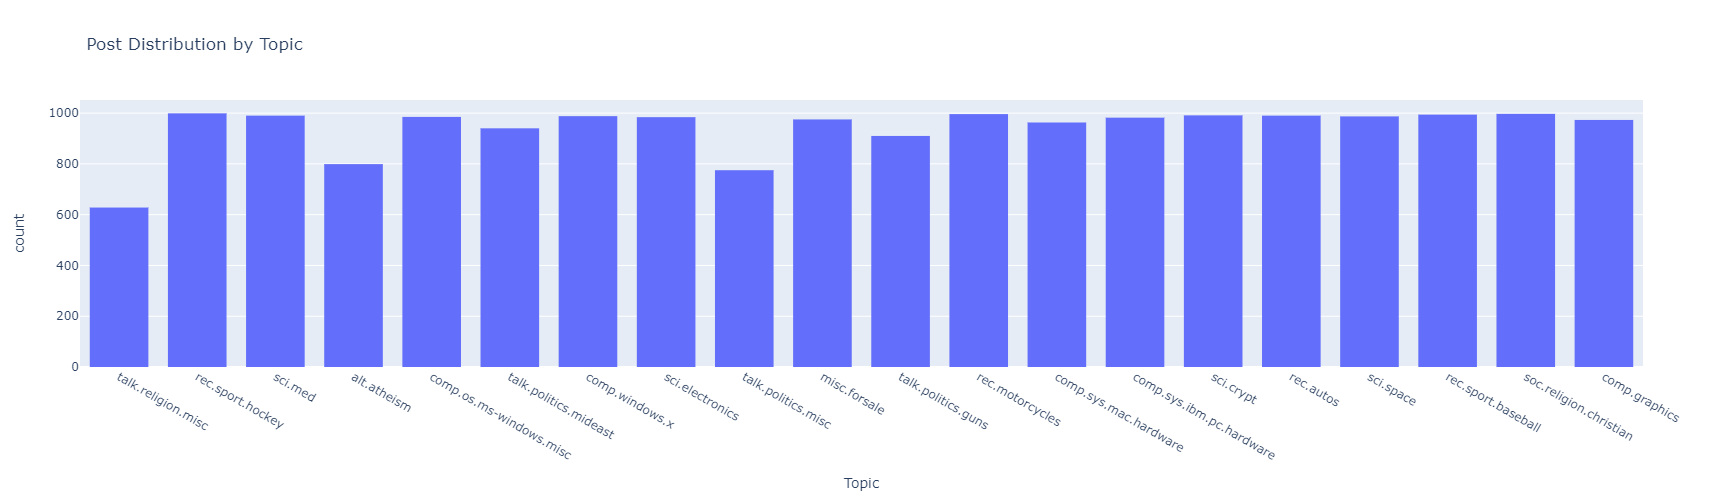

In [6]:

Categories = pd.DataFrame([data_all.target_names[index] for index in data_all.target], columns = ["Topic"])
fig = px.histogram(Categories, x="Topic", title="Post Distribution by Topic", labels = {"x":"Topic", "y":"Post Count"})
fig.update_layout(height=500, width=1000,bargap=.25)


In [7]:
%%time
word_count_vectorizer = CountVectorizer()
word_counts=word_count_vectorizer.fit_transform(data_all.data)

Wall time: 13.4 s


In [8]:
from scipy.sparse import csr_matrix
A = csr_matrix(word_counts)
d = {"Count":np.array(A.sum(axis=1).flatten())[0], "Topic":[data_all.target_names[r] for r in data_all.target]}

count_df = pd.DataFrame(d)

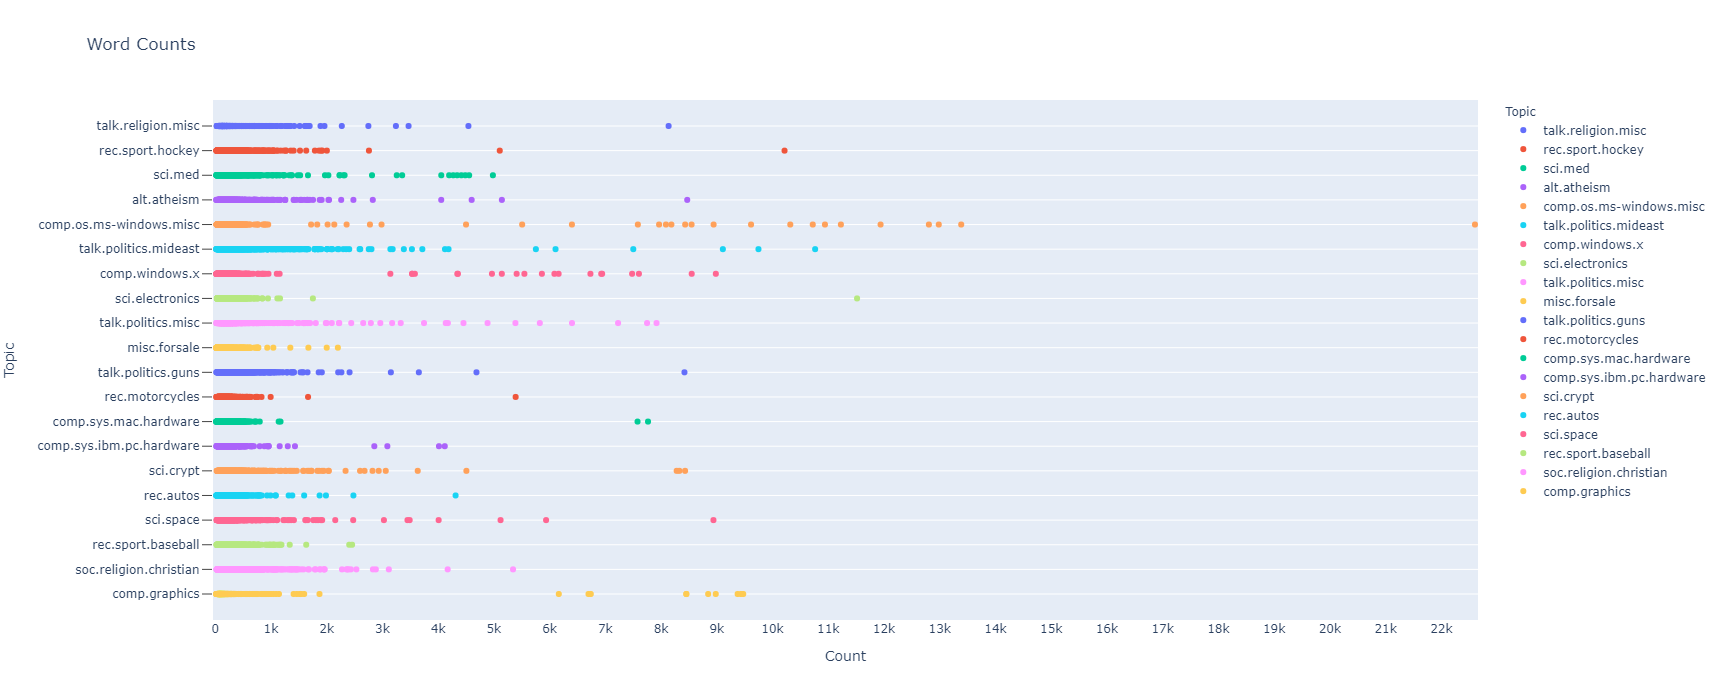

In [9]:
#print(count_df.sort_values("Count"))
#fig = px.histogram(count_df, x="Count", nbins=1000)
fig = px.strip(count_df, y="Topic", x="Count", color = "Topic", orientation="v", title="Word Counts per Post")
fig.update_layout(height=700, width=1500, title="Word Counts", bargap=.25)
fig.update_xaxes(nticks=30)
fig.update_yaxes(ticks="outside", tickwidth=1, ticklen=10, col=1)
fig.show()

## Pre-processing

![steps](https://github.com/dhairavc/DATA-698-Analytics-Master-s-Research-Project/raw/main/steps-2.png)

As with non-language datasets we will perform the pre-processing and various cleaning methods to prior to building the features of the dataset. There are numerous strategies and methods of pre-processing textual data such as but not limited to lower casing, removal of stop words/frequent words/non-alphabetic words, stepping, lemmatization, spell corrections, emoji conversions, removal of URLs/HTML tags, etc. The application of a certain method or a set of methods (the pre-processing strategy) will largely depend on the nature of the text application at hand. In general, “cleaning” the corpus prior to running classifier models against it help reduce noise by removing “bits” of text that would otherwise be irrelevant in the grand scheme of identifying a document to the correct topic.

In [10]:
example_vectorizer = CountVectorizer(lowercase=False)
example_vect_fit = example_vectorizer.fit_transform(data_train.data)
print(example_vect_fit.shape)
o=example_vect_fit.shape[1]
print(f"Total terms/words in corpus: {o} \n")
print("List of words in corpus (first 500): ")
print(example_vectorizer.get_feature_names()[:500])

(11314, 120609)
Total terms/words in corpus: 120609 

List of words in corpus (first 500): 
['00', '000', '0000', '00000', '000000', '00000000', '0000000004', '00000000B', '00000001', '00000001B', '00000010', '00000010B', '00000011', '00000011B', '00000074', '00000093', '000000E5', '00000100', '00000100B', '00000101', '00000101B', '00000110', '00000110B', '00000111', '00000111B', '000005102000', '00000510200001', '00000EE5', '00001000', '00001000B', '00001001', '00001001B', '00001010', '00001010B', '00001011', '00001011B', '000010AF', '00001100', '00001100B', '00001101', '00001101B', '00001110', '00001110B', '00001111', '00001111B', '000042', '000062David42', '000094', '0001', '00010000', '00010000B', '00010001', '00010001B', '00010010', '00010010B', '00010011', '00010011B', '000100255pixel', '00010100', '00010100B', '00010101', '00010101B', '00010110', '00010110B', '00010111', '00010111B', '00011000', '00011000B', '00011001', '00011001B', '00011010', '00011010B', '00011011', '00011011

Basic clean up items:  
* Header/Footer/Quotes Removal
* Convert to lower case
* Remove non-alphabetic characters
* Unicode Normalization


![Unicode](https://github.com/dhairavc/DATA-698-Analytics-Master-s-Research-Project/raw/main/unicode.png)

_Image source: [BetterProgramming](https://betterprogramming.pub/unicode-equivalence-72c152e7b098)_


### Remove Stop Words

Stop words are a subset of conjunctions, prepositions, and/or particle words. Examples are “as” “a”, “is”, “then”, “the”, and many others. Such which lend very limited mean to the context of document classification as they are generally observed across all topics, this is because stopwords are used to construct a sentence to give a sentence context, but do not contain any information about the sentence. The method of stop word removal was to utilize a set of pre-defined words list to create a custom list. The pre-defined stop words sets were from the sklearn.feature_extraction and nltk.corpus  packages, combined with 4 ("don't", "like", "can't", "huh") custom words not found in the pre-defined packages.

In [11]:
%%time

#Credit: The Natural Language Processing Workshop Chapter 2: Stop Words
#--------------------------------------------------------------------
def remove_stop_words_regex(text,stop_word_list):
    return ' '.join([word for word in regexp_tokenize(text, "[\w']+") if word.lower() not in stop_word_list])
#---------------------------------------------------------------------

custom_stopwords = list(text.ENGLISH_STOP_WORDS) + stopwords.words('english') + ["don't", "like", "can't", "huh"]
custom_stopwords = list(np.unique(np.array(custom_stopwords)))


for i in range(len(data_train.data)):
    data_train.data[i] = remove_stop_words_regex(data_train.data[i],custom_stopwords)
    
for i in range(len(data_test.data)):
    data_test.data[i] = remove_stop_words_regex(data_test.data[i],custom_stopwords)



Wall time: 21.3 s


In [12]:
print(custom_stopwords)

['a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'ain', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'amoungst', 'amount', 'an', 'and', 'another', 'any', 'anyhow', 'anyone', 'anything', 'anyway', 'anywhere', 'are', 'aren', "aren't", 'around', 'as', 'at', 'back', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'below', 'beside', 'besides', 'between', 'beyond', 'bill', 'both', 'bottom', 'but', 'by', 'call', 'can', "can't", 'cannot', 'cant', 'co', 'con', 'could', 'couldn', "couldn't", 'couldnt', 'cry', 'd', 'de', 'describe', 'detail', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'done', 'down', 'due', 'during', 'each', 'eg', 'eight', 'either', 'eleven', 'else', 'elsewhere', 'empty', 'enough', 'etc', 'even', 'ever', 'every', 'everyone', 'everything', 'everywhere', 'except', 'few', 'fifteen', 'fifty', 'fill

### Lemmatization

In the natural language a word will take different grammatic form, but contextually each of the forms holds the same meaning. For example, the words “change”, “changing”, “changes”, and “changed” hold roughly the same meaning. Normalizing occurrences to a single word “change” would reduce redundant features. Generally, there are two approaches to this normalization, Stemming or Lemmatization. 

Normalization via Stemming is the process reducing words to their root and discarding the suffix. In the above example the root word is considered “chang” and the suffixs are considered “e”, “ed”, “ing”, “s”.  Normalization via Lemmatization is reducing words by use of its vocabulary and position in a sentence. The normalized word is referred to a lemma and is often more understandable than the same stemmed word. For example, the words the words “change”, “changing”, “changes”, and “changed” will reduce to the lemma “change”. The is more interpretable than the stemmed word “chang”. 

 This pattern-based approach of stemming is fast and simple but is equivalent of using brute force. In comparison Lemmatization is more resource costly, but will generally produce more readable outcomes. Using Stemming over Lemmatization or vice versa has a precision/recall tradeoff, such that Stemming will increase recall at the expense of precision while Lemmatization will increase recall without hurting precision 


![Lemmatization](https://github.com/dhairavc/DATA-698-Analytics-Master-s-Research-Project/raw/main/lemmatizing.JPG)

_Image Credit: [Importance of Text Pre-processing](https://www.pluralsight.com/guides/importance-of-text-pre-processing)_

In [13]:
%%time
#Credit: Lemmatization Approaches with Examples in Python
#----------------------------------------------------
def run_lemmatizer(t):
    t = re.sub(r'[^A-Za-z ]', ' ', t)
    blob = TextBlob(t)
    tag_dict = {"J": 'a', "N": 'n', "V": 'v', "R": 'r'}
    wt = [(w, tag_dict.get(pos[0], 'n')) for w, pos in blob.tags]    
    lemmatized = [wd.lemmatize(tag) for wd, tag in wt]
    return " ".join(lemmatized)
#----------------------------------------------------

for i in range(len(data_train.data)):
    data_train.data[i] = run_lemmatizer(data_train.data[i])
    
for i in range(len(data_test.data)):
    data_test.data[i] = run_lemmatizer(data_test.data[i])

Wall time: 3min 20s


In [14]:
%%time
train_vectorizer = CountVectorizer(stop_words = "english", strip_accents = "unicode", min_df=10)
train_vect_fit = train_vectorizer.fit_transform(data_train.data)
test_vect_fit = train_vectorizer.transform(data_test.data)


f = train_vect_fit.shape[1]

print(f"Total terms/words in corpus BEFORE Pre-Processing: {o}")
print(f"Total terms/words in corpus AFTER Pre-Processing: {f} \n")



Total terms/words in corpus BEFORE Pre-Processing: 120609
Total terms/words in corpus AFTER Pre-Processing: 8093 

Wall time: 1.89 s


In [15]:
print(train_vectorizer.get_feature_names()[:500])


['aa', 'aaa', 'aaron', 'ab', 'abandon', 'abbreviation', 'abc', 'abide', 'ability', 'able', 'abolish', 'abomination', 'abort', 'abortion', 'abraham', 'abroad', 'abs', 'absence', 'absent', 'absolute', 'absolutely', 'absorb', 'abstract', 'absurd', 'absurdity', 'abuse', 'abusive', 'ac', 'acad', 'academia', 'academic', 'academy', 'accelerate', 'acceleration', 'accelerator', 'accept', 'acceptable', 'acceptance', 'accepted', 'accepts', 'access', 'accessible', 'accessory', 'accident', 'accidental', 'accidentally', 'accommodate', 'accomodate', 'accompany', 'accomplish', 'accord', 'accordance', 'according', 'account', 'accountability', 'accountable', 'accounting', 'accounts', 'accumulate', 'accuracy', 'accurate', 'accurately', 'accusation', 'accuse', 'ace', 'achieve', 'achievement', 'acid', 'ack', 'acknowledge', 'aclu', 'acm', 'acquire', 'acquisition', 'acronym', 'act', 'action', 'activate', 'active', 'actively', 'activist', 'activity', 'acts', 'actual', 'actually', 'acute', 'ad', 'adam', 'adams

### Document Term Matrix

The above pre-processing steps are done and then our entire text corpus is turned into a Document Term Matrix (DTM) such that for the entirety of our tokens are represented by columns on the matrix and each post is represented as rows in the matrix. The columns are essentially features of the dataset and each row an observation. The DTM holds the term frequency per document per term such that:

![DTM](https://github.com/dhairavc/DATA-698-Analytics-Master-s-Research-Project/raw/main/DTM.png)

Wall time: 3min 18s


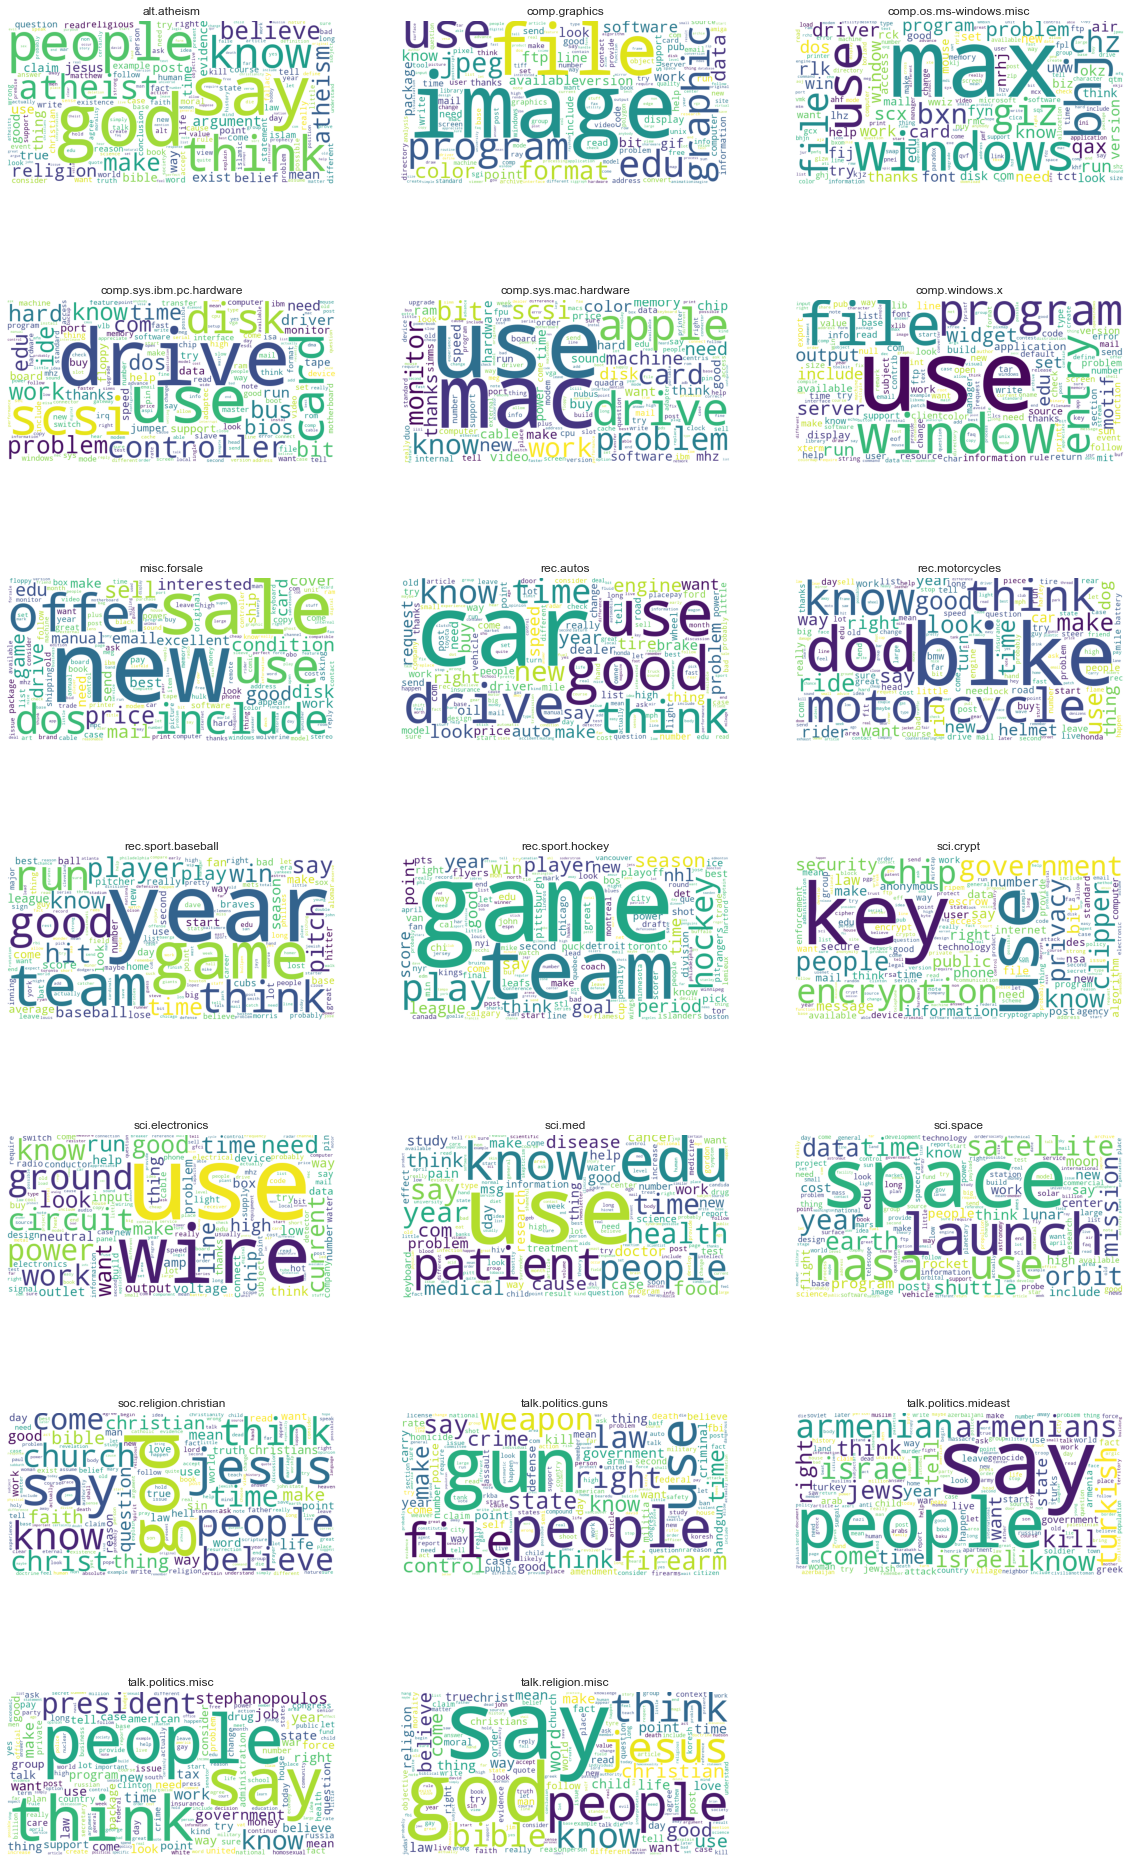

In [16]:
%%time
category_df = pd.DataFrame(columns = ["Word", "Count", "Category"])
fig = plt.figure(figsize = (20,35))


for i in data_all.target_names:
    cat_docs = fetch_20newsgroups(data_home='/path/to/data',
                                subset='train', remove = ("headers", "footers", "quotes"),
                                shuffle=True, random_state=5, categories=[i])
    for k in range(len(cat_docs.data)):
        cat_docs.data[k] = remove_stop_words_regex(cat_docs.data[k],custom_stopwords)
    for j in range(len(cat_docs.data)):
        cat_docs.data[j] = run_lemmatizer(cat_docs.data[j])
    cat_vect = CountVectorizer(stop_words = "english", strip_accents = "unicode", analyzer='word', token_pattern='[a-zA-Z]{3,}', min_df=2)
    #cat_vect = CountVectorizer(stop_words = "english", strip_accents = "unicode", min_df=3)
    cat_counts = cat_vect.fit_transform(cat_docs.data)
    cat_word_names = cat_vect.get_feature_names()
    cat_word_counts = np.array(cat_counts.sum(axis=0))[0]
    cat_word_dict = dict(zip(cat_word_names, cat_word_counts))
    cat_count_df = pd.DataFrame(list(cat_word_dict.items()), columns=["Word", "Count"])
    cat_count_df["Category"] = i
    category_df = category_df.append(cat_count_df, ignore_index = True)
    ax = fig.add_subplot(7,3, data_all.target_names.index(i)+1)
    wordcloud = WordCloud(min_word_length =3, background_color='white', width=800, height=400, stopwords = custom_stopwords)
    wordcloud.generate_from_frequencies(cat_word_dict)
    ax.imshow(wordcloud)
    ax.set_title(i)
    ax.axis("off")


## Feature Engineering 


![steps](https://github.com/dhairavc/DATA-698-Analytics-Master-s-Research-Project/raw/main/steps-3.png)

In this step for each document in D, the raw text will be transformed into a feature vector using the Term Frequency – Inverse Document Frequency vectorizer (TF-IDF). The TF-IDF aims to express importance of specific words in a given document di  compared all words in the document collection D

### Term Frequency – Inverse Document Frequency vectorizer (TF-IDF)

![TFIDF](https://github.com/dhairavc/DATA-698-Analytics-Master-s-Research-Project/raw/main/tfidf.png)  
_Image Credit: [What and Why is TF-IDF Important for SEO](https://www.tmblast.com/blog/seo/what-and-why-is-tf-idf-important-for-seo/)_

In [17]:
train_tfidf_transformer = TfidfTransformer(smooth_idf=True,use_idf=True)


train_tfidf = train_tfidf_transformer.fit_transform(train_vect_fit)
test_tfidf = train_tfidf_transformer.transform(test_vect_fit)

print(test_tfidf.shape)
print(train_tfidf.shape)

(7532, 8093)
(11314, 8093)


Once you have the IDF values, you can now compute the tf-idf scores for any document or set of documents.

In [18]:
i=714
print("Category: " + data_train.target_names[data_train.target[i]] + "\n")
print("\n".join(data_train.data[i].split("\n")[:]))
e = { "Term":train_vectorizer.get_feature_names(),
      "TF-IDF":train_tfidf[i].T.todense().flatten().tolist()[0]
    }
doc_tdidf = pd.DataFrame(e)
print(" ")
(doc_tdidf[doc_tdidf["TF-IDF"] > 0]).sort_values(by=["TF-IDF"], ascending=False)


Category: sci.space

point see copy Lunar Resources Data Purchase Act know Moon authorize U government purchase lunar science data private non profit vendor select basis competitive bidding aggregate cap bid award million copy want legalese contain Federal legislation free resource evaluate local congressional office list phone book staff people forward copy legal expert Simply ask consider support Lunar Resources Data Purchase Act feedback negative positive congressional office forward David Anderman E Yorba Linda Blvd Apt G Fullerton CA E Mail David Anderman ofa fidonet org resource local chapter National Space Society Members chapter happy work evaluate support Moon address telephone number near chapter send E mail check late issue Ad Astra library near Finally request receive information Moon send request database recently corrupt information lose author thank patience
 


Term    TF-IDF
4260      lunar  0.277972
1120    chapter  0.264847
4619       moon  0.251423
5696   purchase  0.221791
6043  resources  0.212411
...         ...       ...
5410      point  0.047831
7803       want  0.043169
7939       work  0.042994
5247     people  0.040856
3979       know  0.035270

[81 rows x 2 columns]

## Classification Models

![steps](https://github.com/dhairavc/DATA-698-Analytics-Master-s-Research-Project/raw/main/steps-4.png)

The step after TF-IDF Vectorization is to build classification models to which the training data is supplied. The models implemented here are Support Vector Machines, Naïve Bayes, and Random Forests. 
  
For each model a set of parameters can be tuned to attain optimal results. We cycle through a set of hyper-parameters using GridSearchCV and RandomizedSearchCV within the sklearn package. GridSearch is an exhaustive method that cycle through every hyper-parameter and can be computationally expensive. Where feasible RandomizedSearch has been used to tune hyper-parameters, which have shown to be more efficient than GridSearch.
Each model has been build using cross validation of the training data to minimizing overfitting.

### Support Vector Machine

The primary goal of Support Vector Machines (SVM) is to determine a decision boundary between classes with maximum separation. Between classes there can be an infinite number of decision boundaries. The points from each class closest to the decision boundary are called Support Vectors. SVM looks to find an optimal decision boundary such that Support Vectors from each class have a maximum decision boundary and each class is on different sides of the decision boundary. Classification of a new unseen point (X_i) is determined on which side of the decision boundary X_i resides on. Below shows a simple binary classification with linearly separable classes and two features (X1 and X2).

![SVM1](https://github.com/dhairavc/DATA-698-Analytics-Master-s-Research-Project/raw/main/SVM1.png)

For data that is not linearly separable due to either overlapping or in an nth dimensional space for n number of features, SVM utilizes kernel functions (also called kernel trick) to transform the feature space from n dimensions to a higher n+y dimensions to achieve better separation of classes. The separating boundary in this higher dimension is called a hyperplane.

![SVM2](https://github.com/dhairavc/DATA-698-Analytics-Master-s-Research-Project/raw/main/SVM2.png)

In [19]:
%%time
svm_ti = time.time()
param_rand = { 'C':[.01, 1, 10, 100],'kernel':["poly", "rbf"],'degree':[4,5,6,7], "gamma":["scale", "auto", .01, .001, .1]}
svm_rand = RandomizedSearchCV(SVC(),param_rand, cv=3, n_jobs=5)
svm_rand.fit(train_tfidf, data_train.target)
print("Best Parameters: " + str(svm_rand.best_params_))
svm_rand_pred = svm_rand.predict(test_tfidf)
svm_tf = time.time()
svm_rt = exec_time(svm_ti, svm_tf)
svm_rand_train_pred = svm_rand.predict(train_tfidf)
svm_train_acc = metrics.accuracy_score(y_true=data_train.target, y_pred = svm_rand_train_pred)
svm_test_acc = metrics.accuracy_score(y_true=data_test.target, y_pred = svm_rand_pred)

Best Parameters: {'kernel': 'rbf', 'gamma': 'scale', 'degree': 4, 'C': 100}
Wall time: 14min 16s


Train Accuracy: 0.97
Wall time: 1min 38s


0.9719816156973661

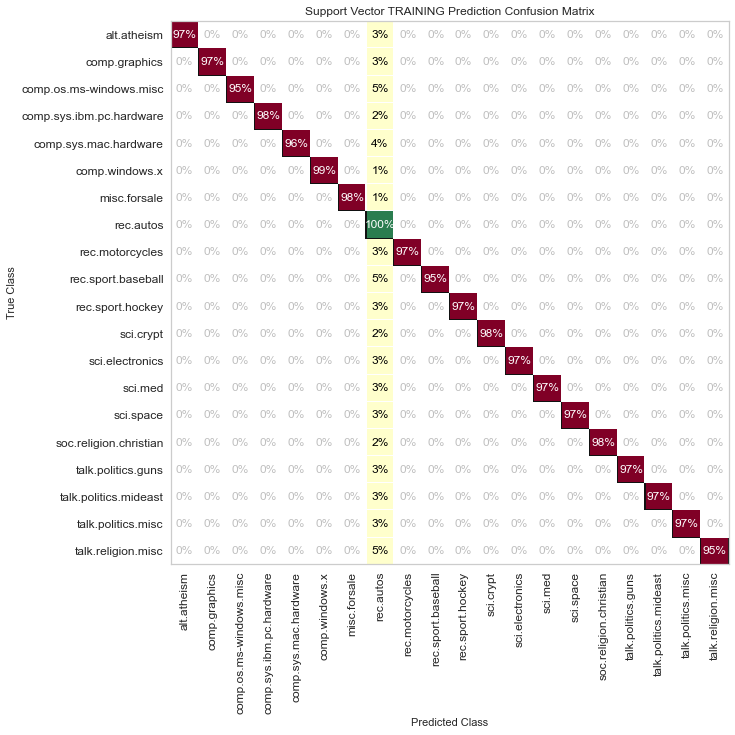

In [20]:
%%time
print("Train Accuracy: " + str(round(svm_train_acc,2)))
plt.figure(figsize=(10,10))
plt.title("Support Vector TRAINING Prediction Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
visualizer = ConfusionMatrix(svm_rand, classes=data_train.target_names, percent=True)
visualizer.fit(train_tfidf, data_train.target)
visualizer.score(train_tfidf, data_train.target)

                          precision    recall  f1-score   support

             alt.atheism       0.47      0.47      0.47       319
           comp.graphics       0.58      0.69      0.63       389
 comp.os.ms-windows.misc       0.65      0.60      0.62       394
comp.sys.ibm.pc.hardware       0.66      0.67      0.66       392
   comp.sys.mac.hardware       0.73      0.66      0.69       385
          comp.windows.x       0.82      0.64      0.72       395
            misc.forsale       0.76      0.78      0.77       390
               rec.autos       0.47      0.73      0.57       396
         rec.motorcycles       0.67      0.72      0.69       398
      rec.sport.baseball       0.84      0.77      0.80       397
        rec.sport.hockey       0.92      0.84      0.88       399
               sci.crypt       0.85      0.65      0.74       396
         sci.electronics       0.53      0.62      0.57       393
                 sci.med       0.77      0.74      0.76       396
         

0.6659585767392459

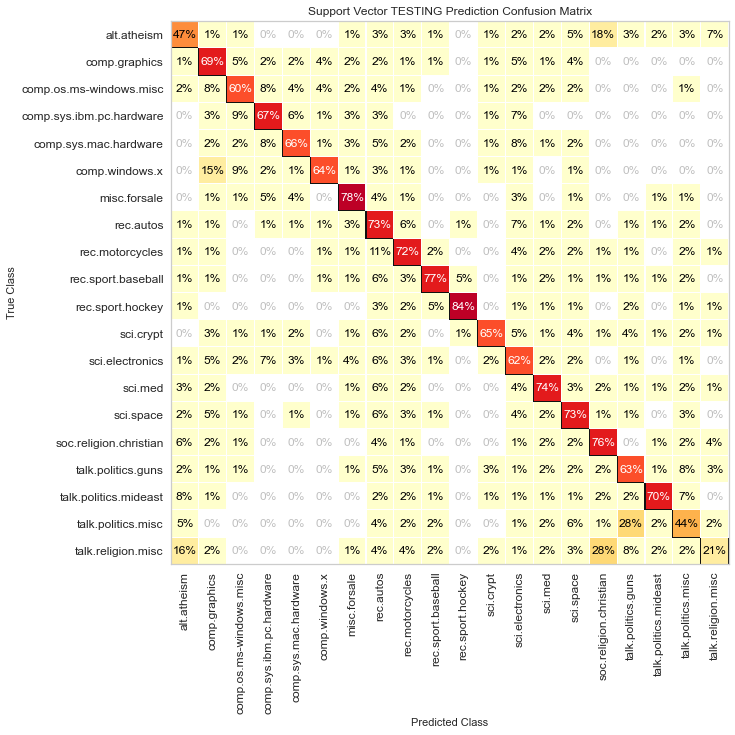

In [21]:
%%time
print(metrics.classification_report(data_test.target, svm_rand_pred, target_names=data_test.target_names))
svm_precision, svm_recall, svm_fscore, _ = metrics.precision_recall_fscore_support(y_true=data_test.target, y_pred = svm_rand_pred, average = "macro")
print("Test Accuracy: " + str(round(svm_test_acc,2)))
plt.figure(figsize=(10,10))
plt.title("Support Vector TESTING Prediction Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
visualizer = ConfusionMatrix(svm_rand, classes=data_train.target_names, percent=True, is_fitted=True)
visualizer.fit(test_tfidf, data_test.target)
visualizer.score(test_tfidf, data_test.target)

### Naïve Bayes Classifier (Multinomial)

Naïve Bayes is a set of probabilistic algorithms that utilizes Bayes’ Theorem and probability theory to make predictions such that the algorithm looks to determine the probability of an event A given the probability that another event B has already occurred. 

Within the Naïve Bayes family of classifiers, the Multinomial Naïve Bayes classifier is most suited for text classification. This is because while both algorithms function similarly simple Naïve Bayes treats a post of a given class as a set of terms that are either present or not present, the Multinomial Naïve Bayes algorithm considers term frequency


![nb](https://github.com/dhairavc/DATA-698-Analytics-Master-s-Research-Project/raw/main/nb.png)  
_Image Credit: [Naïve bayes Classifier From Scratch With Hands On Examples in R](https://insightimi.wordpress.com/2020/04/04/naive-bayes-classifier-from-scratch-with-hands-on-examples-in-r/)_

In [22]:
%%time
nb_ti = time.time()
param_grid = { 'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 2, 5, .5, .75) }
nb_grid = GridSearchCV(MultinomialNB(),param_grid, n_jobs=5, cv=5)
nb_grid.fit(train_tfidf, data_train.target)
print("Best Parameters: " + str(nb_grid.best_params_))
nb_grid_pred = nb_grid.predict(test_tfidf)
nb_tf = time.time()
nb_rt = exec_time(nb_ti, nb_tf)
nb_grid_train_pred = nb_grid.predict(train_tfidf)


nb_train_acc = metrics.accuracy_score(y_true=data_train.target, y_pred = nb_grid_train_pred)
nb_test_acc = metrics.accuracy_score(y_true=data_test.target, y_pred = nb_grid_pred)



Best Parameters: {'alpha': 0.1}
Wall time: 6.72 s


Train Accuracy: 0.9
Wall time: 295 ms


0.8967650698249956

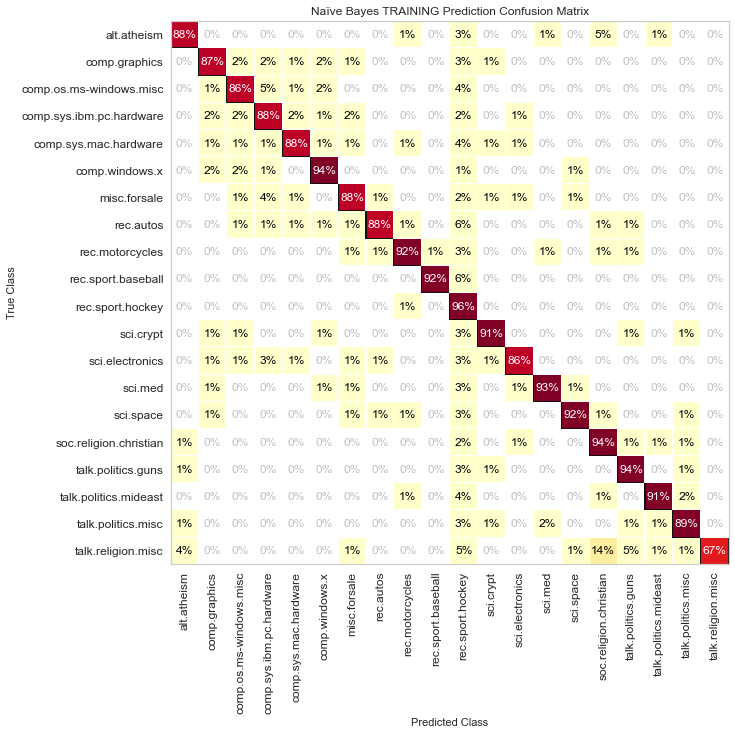

In [23]:
%%time
print("Train Accuracy: " + str(round(nb_train_acc,2)))
plt.figure(figsize=(10,10))
plt.title("Naïve Bayes TRAINING Prediction Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
visualizer = ConfusionMatrix(nb_grid, classes=data_train.target_names, percent=True)
visualizer.fit(train_tfidf, data_train.target)
visualizer.score(train_tfidf, data_train.target)


                          precision    recall  f1-score   support

             alt.atheism       0.52      0.43      0.47       319
           comp.graphics       0.60      0.67      0.63       389
 comp.os.ms-windows.misc       0.59      0.56      0.58       394
comp.sys.ibm.pc.hardware       0.60      0.64      0.62       392
   comp.sys.mac.hardware       0.69      0.66      0.67       385
          comp.windows.x       0.78      0.76      0.77       395
            misc.forsale       0.76      0.74      0.75       390
               rec.autos       0.74      0.68      0.71       396
         rec.motorcycles       0.75      0.72      0.73       398
      rec.sport.baseball       0.89      0.79      0.84       397
        rec.sport.hockey       0.57      0.92      0.70       399
               sci.crypt       0.79      0.73      0.76       396
         sci.electronics       0.64      0.53      0.58       393
                 sci.med       0.81      0.75      0.78       396
         

0.6776420605416887

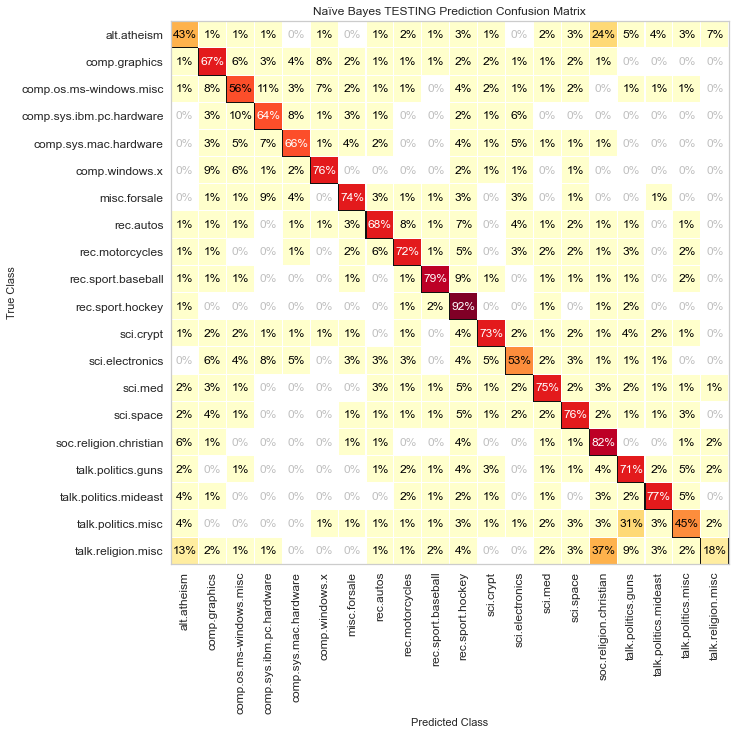

In [24]:
%%time
print(metrics.classification_report(data_test.target, nb_grid_pred, target_names=data_test.target_names))
nb_precision, nb_recall, nb_fscore, _ = metrics.precision_recall_fscore_support(y_true=data_test.target, y_pred = nb_grid_pred, average = "macro")
print("Test Accuracy: " + str(round(nb_test_acc,2)))
plt.figure(figsize=(10,10))
plt.title("Naïve Bayes TESTING Prediction Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
visualizer = ConfusionMatrix(nb_grid, classes=data_train.target_names, percent=True)
visualizer.fit(test_tfidf, data_test.target)
visualizer.score(test_tfidf, data_test.target)



### Random Forest

A Decision Tree is a type of supervised learning model where the data is recursively split into two or more sub-populations given a criterion. Each split is headed by a node, where the upper most node is called the root node, and nodes which cannot be split further are called terminal (leaf) nodes. All other nodes are considered internal nodes. Based on a given population of observations, the population is split into sub-populations with the criteria that each split separates the sub-population better than the previous split. This recursive splitting cycles through the different predictor variables in order to find leaf nodes that make the purest class separation or most accurate predictions.

The Random Forest model is an ensemble method built from many individual decision trees and the classification output is determined by majority voting. The method aims to reduce the variance of individual trees and is particularly suited when predictors exhibit collinearity. Each tree in the forest is constructed using bootstrapped observations and a randomized subset of features. The forest growing procedure is controlled by two tuning parameters that we seek to optimize the number of trees in the forest and the number of random variables used to build each tree


![RF](https://github.com/dhairavc/DATA-698-Analytics-Master-s-Research-Project/raw/main/Random%20Forest2.png)

In [25]:
%%time
rf_ti = time.time()
param_rand = { 'n_estimators': (10, 100, 500, 1000),
                'criterion': ('gini', 'entropy'),
                'max_features': ("sqrt", "log2"),
             }

rf_rand = RandomizedSearchCV(RandomForestClassifier(oob_score=True),param_rand, n_jobs=5)
rf_rand.fit(train_tfidf, data_train.target)
print("Best Parameters: " + str(rf_rand.best_params_))
rf_rand_pred = rf_rand.predict(test_tfidf)
rf_tf = time.time()
rf_rt = exec_time(rf_ti, rf_tf)

rf_rand_train_pred = rf_rand.predict(train_tfidf)

rf_train_acc = metrics.accuracy_score(y_true=data_train.target, y_pred = rf_rand_train_pred)
rf_test_acc = metrics.accuracy_score(y_true=data_test.target, y_pred = rf_rand_pred)

Best Parameters: {'n_estimators': 1000, 'max_features': 'log2', 'criterion': 'gini'}
Wall time: 46min 33s


Train Accuracy: 0.97
Wall time: 35.8 s


0.9719816156973661

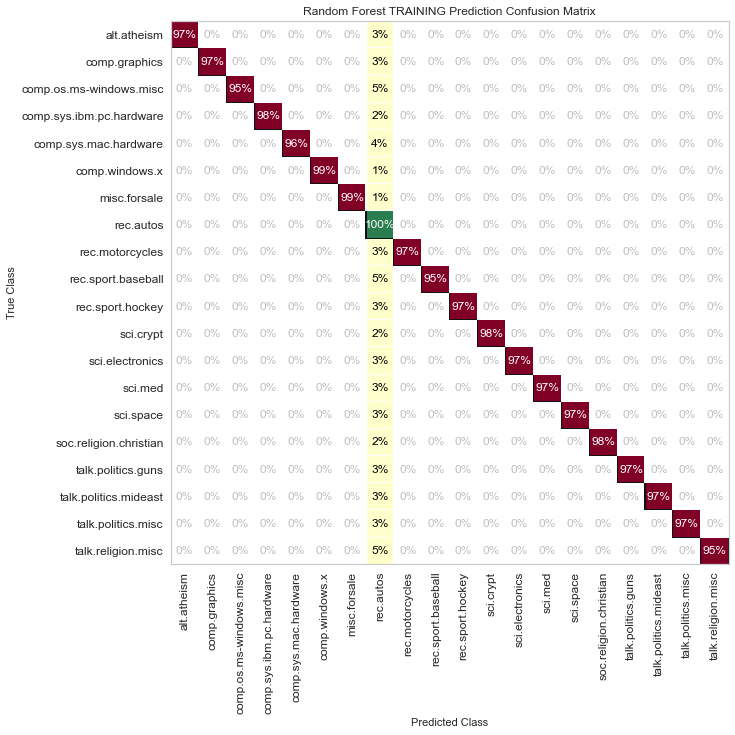

In [26]:
%%time
print("Train Accuracy: " + str(round(rf_train_acc,2)))
plt.figure(figsize=(10,10))
plt.title("Random Forest TRAINING Prediction Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
visualizer = ConfusionMatrix(rf_rand, classes=data_train.target_names, percent=True)
visualizer.fit(train_tfidf, data_train.target)
visualizer.score(train_tfidf, data_train.target)

                          precision    recall  f1-score   support

             alt.atheism       0.51      0.43      0.47       319
           comp.graphics       0.61      0.62      0.61       389
 comp.os.ms-windows.misc       0.60      0.66      0.63       394
comp.sys.ibm.pc.hardware       0.65      0.61      0.63       392
   comp.sys.mac.hardware       0.65      0.65      0.65       385
          comp.windows.x       0.67      0.71      0.69       395
            misc.forsale       0.69      0.79      0.74       390
               rec.autos       0.45      0.71      0.55       396
         rec.motorcycles       0.70      0.73      0.71       398
      rec.sport.baseball       0.71      0.81      0.76       397
        rec.sport.hockey       0.85      0.86      0.86       399
               sci.crypt       0.84      0.68      0.75       396
         sci.electronics       0.59      0.47      0.52       393
                 sci.med       0.77      0.69      0.73       396
         

0.6530801911842804

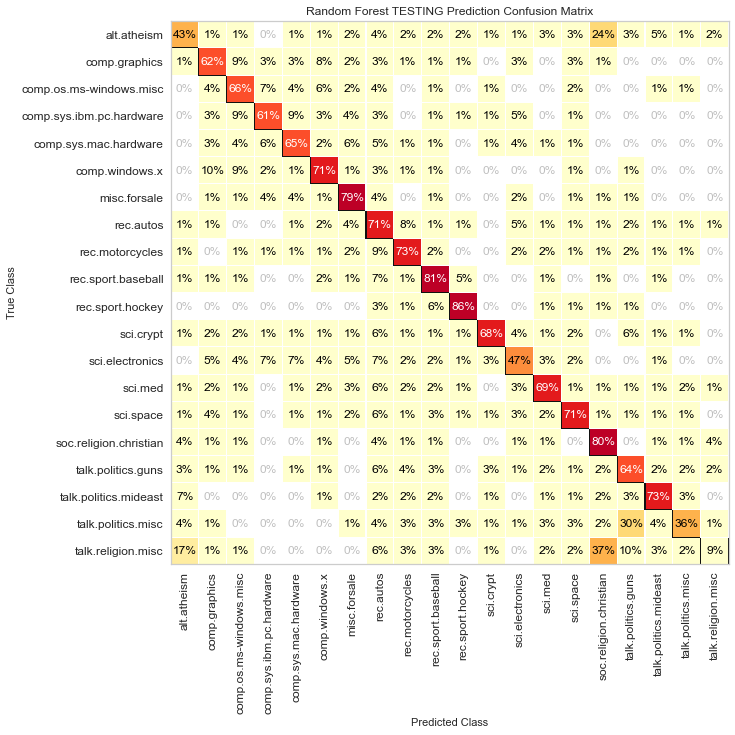

In [27]:
%%time
print(metrics.classification_report(data_test.target, rf_rand_pred, target_names=data_test.target_names))
rf_precision, rf_recall, rf_fscore, _ = metrics.precision_recall_fscore_support(y_true=data_test.target, y_pred = rf_rand_pred, average = "macro")
print("Test Accuracy: " + str(round(rf_test_acc,2)))
plt.figure(figsize=(10,10))
plt.title("Random Forest TESTING Prediction Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
visualizer = ConfusionMatrix(rf_rand, classes=data_train.target_names, percent=True)
visualizer.fit(test_tfidf, data_test.target)
visualizer.score(test_tfidf, data_test.target)

## Model Evaluation

![steps](https://github.com/dhairavc/DATA-698-Analytics-Master-s-Research-Project/raw/main/steps-5.png)

We’ve ran 3 models on the same training and testing data. The below shows a summary for the training and testing metrics of each of the models 

In [28]:

d = {"Model":["Support Vector Machine", "Naïve Bayes", "Random Forest"],
     "Training Accuracy":[svm_train_acc, nb_train_acc, rf_train_acc],
     "Testing Accuracy": [svm_test_acc, nb_test_acc, rf_test_acc], 
     "Precision": [svm_precision, nb_precision, rf_precision],
     "Recall": [svm_recall, nb_recall, rf_recall],
     "F-Score": [svm_fscore, nb_fscore, rf_fscore], 
     "Execution Time": [svm_rt, nb_rt, rf_rt]
    }
acc_df = pd.DataFrame(d)
round(acc_df, 2)

Model  Training Accuracy  Testing Accuracy  Precision  \
0  Support Vector Machine               0.97              0.67       0.67   
1             Naïve Bayes               0.90              0.68       0.68   
2           Random Forest               0.97              0.65       0.65   

   Recall  F-Score Execution Time  
0    0.65     0.65       00:13:28  
1    0.66     0.66       00:00:07  
2    0.64     0.63       00:46:16

![PR](https://github.com/dhairavc/DATA-698-Analytics-Master-s-Research-Project/raw/main/presision-recall.png)

Precision is defined as the ratio of correctly predicted positive observations to the overall total predicted positive observations. In other words, of the ones that were predicted as a topic, how many where actually that topic. Recall is defined as ratio of correctly predicted positive observations compared to all observations in this class. In other words, Recall is the ratio of how good the model is at identifying a topic. The F1-Score is the weighted average of the Precision and Recall Scores. For our dataset, we will want to maximize the F1-Score and while Support Vector Machine and Naïve Bayes models have the same F1-Scores, we can look at the individual F1-Scores per Topic 

In [29]:
svm_metrics = pd.DataFrame(metrics.classification_report(data_test.target, svm_rand_pred, target_names=data_test.target_names, output_dict=True)).transpose()
svm_metrics.columns = ["SVM Precision", "SVM Recall", "SVM F1-Score", "SVM Support"]

nb_metrics = pd.DataFrame(metrics.classification_report(data_test.target, nb_grid_pred, target_names=data_test.target_names,output_dict=True)).transpose()
nb_metrics.columns = ["NB Precision", "NB Recall", "NB F1-Score", "NB Support"]


rf_metrics = pd.DataFrame(metrics.classification_report(data_test.target, rf_rand_pred, target_names=data_test.target_names, output_dict=True)).transpose()
rf_metrics.columns = ["RF Precision", "RF Recall", "RF F1-Score", "RF Support"]

metrics_df = pd.concat([(pd.concat([svm_metrics, nb_metrics], axis=1)), rf_metrics], axis=1)

metrics_df.reset_index(inplace=True)
metrics_df = metrics_df.rename(columns={"index":"Category"})

The below shows that the F1-Score is generally same across all models with some slight variation. All models performed poorly on talk.religion.misc and alt.athesim. talk.politics was another topic that performed poorly

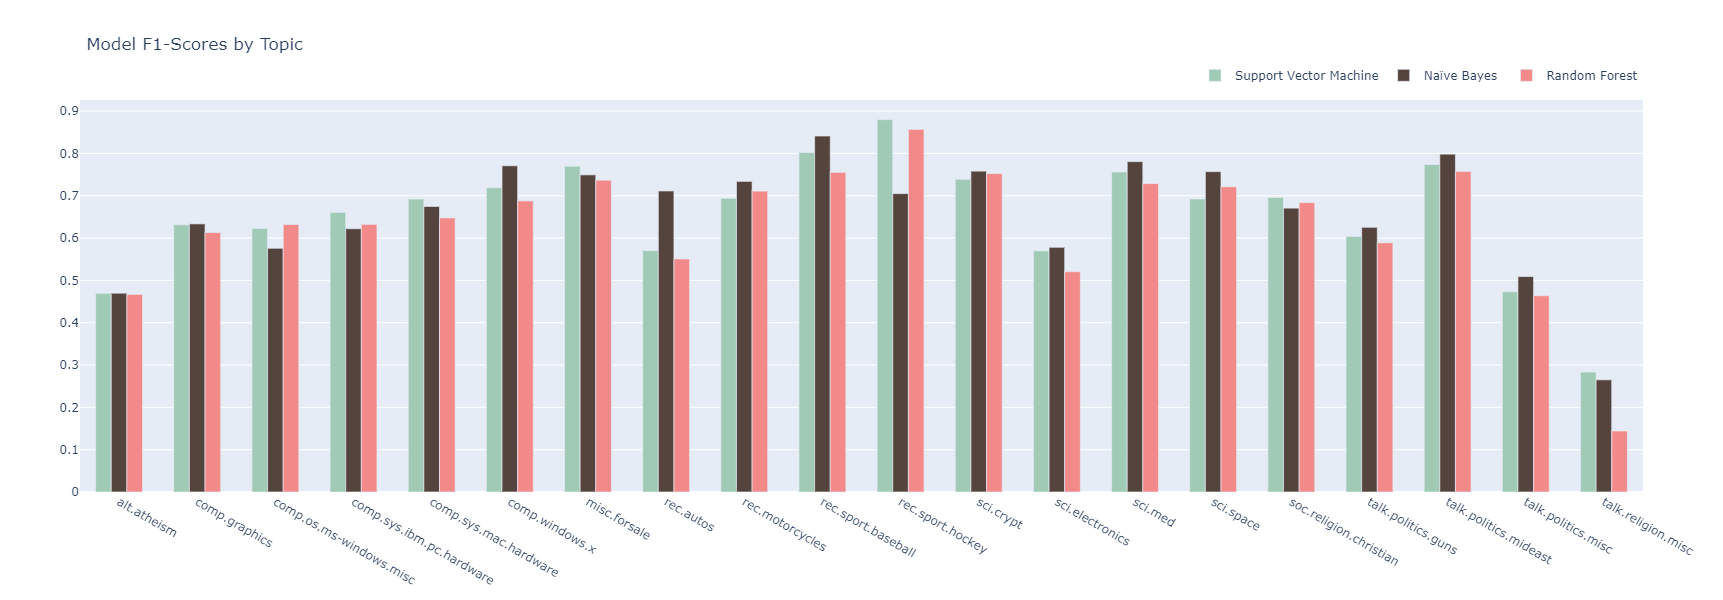

In [30]:

fig = go.Figure()
fig.add_trace(go.Bar(name = "Support Vector Machine", y=list(metrics_df.iloc[0:20]["SVM F1-Score"]), x=metrics_df["Category"], marker=dict(color="rgb(160,202,181)"))),
fig.add_trace(go.Bar(name = "Naïve Bayes ", y=list(metrics_df.iloc[0:20]["NB F1-Score"]), x=metrics_df["Category"], marker=dict(color='rgb(85,68,61)'))),
fig.add_trace(go.Bar(name = "Random Forest", y=list(metrics_df.iloc[0:20]["RF F1-Score"]), x=metrics_df["Category"],marker=dict(color="rgb(243,138,138)")))

fig.update_layout(barmode='group', height=600, width=1000, title="Model F1-Scores by Topic", bargap=.4, legend = dict(orientation="h",xanchor="right", yanchor="top", 
                                                                                                                      y=1.1, x=1))


<timed exec>:26: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



Wall time: 1min 25s


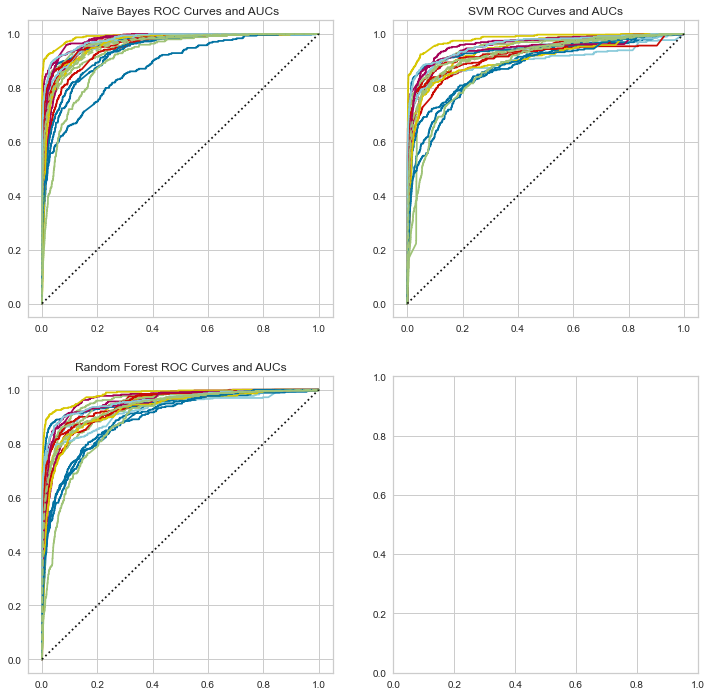

In [31]:
%%time
figx, axes = plt.subplots(2,2, figsize=(12, 12))

nb_AUC= ROCAUC(nb_grid, classes=data_all.target_names, per_class=True, ax=axes[0][0])
nb_AUC.fit(test_tfidf, data_test.target)
nb_AUC.score(test_tfidf, data_test.target)
axes[0][0].set(title = "Naïve Bayes ROC Curves and AUCs")
axes[0][0].legend().set_visible(False)

svm_AUC= ROCAUC(svm_rand, classes=data_all.target_names, per_class=True, ax=axes[0][1])
svm_AUC.fit(test_tfidf, data_test.target)
svm_AUC.score(test_tfidf, data_test.target)
axes[0][1].set(title = "SVM ROC Curves and AUCs")
axes[0][1].legend().set_visible(False)

rf_AUC= ROCAUC(rf_rand, classes=data_all.target_names, per_class=True, ax=axes[1][0])
rf_AUC.fit(test_tfidf, data_test.target)
rf_AUC.score(test_tfidf, data_test.target)
axes[1][0].set(title = "Random Forest ROC Curves and AUCs")
axes[1][0].legend().set_visible(False)

# xf_AUC= ROCAUC(nb_grid, classes=data_all.target_names, per_class=True, ax=axes[1][1])
# xf_AUC.fit(test_tfidf, data_test.target)
# xf_AUC.score(test_tfidf, data_test.target)
# axes[1][1].legend().set_visible(True)

figx.show()

The AUC-ROC curve shows that while Naïve Bayes performed poorly on one topic, it was exceptionally well on the other topics on par with SVM and Random Forest. Random Forest and Support Vector Models were computationally expensive and the execution time (~40mins, ~11mins respectively) of each show this. The Naïve Bayes model on the same testing and training datasets executed in seconds providing far less computational expense for similar accuracy results. Given it’s simplicity and time efficiency for this dataset and given hardware, Naïve Bayes would be the model of choice.

In [43]:
s=["On Monday, the Food and Drug Administration expanded its emergency use authorization for Pfizer's Covid-19 vaccine to include people 12 to 15 years old. And on Thursday, the Centers for Disease Control and Prevention announced fully vaccinated Americans do not need to wear masks or socially distance indoors or outdoors, with some exceptions"]
s[0] = remove_stop_words_regex(s[0],custom_stopwords)
s[0] = run_lemmatizer(s[0])
s = train_vectorizer.transform(s)
s = train_tfidf_transformer.transform(s)

d = {
    "Classifier": ["Support Vector Machine", "Naïve Bayes", "Random Forest"],
    "Prediction": [data_all.target_names[svm_rand.predict(s)[0]], data_all.target_names[nb_grid.predict(s)[0]],data_all.target_names[rf_rand.predict(s)[0]]]
}
pred_df = pd.DataFrame(d)
pred_df = pred_df.set_index("Classifier")

display(pred_df)
S = csr_matrix(s)

e = { "Term":train_vectorizer.get_feature_names(),
      "TF-IDF":(pd.DataFrame.sparse.from_spmatrix(s).T)[0] }
rand_tdidf = pd.DataFrame(e)
print(" ")
(rand_tdidf[rand_tdidf["TF-IDF"] > 0]).sort_values(by=["TF-IDF"], ascending=False)

Prediction
Classifier                       
Support Vector Machine    sci.med
Naïve Bayes               sci.med
Random Forest             sci.med

Term    TF-IDF
1086         centers  0.274492
5538      prevention  0.268545
525    authorization  0.260379
4604          monday  0.240532
2341       emergency  0.240532
7263        thursday  0.234288
4372            mask  0.227140
2510       exception  0.221163
2544          expand  0.215166
2094        distance  0.214743
2076         disease  0.207170
257        americans  0.205499
7845            wear  0.204215
111   administration  0.202671
300         announce  0.198936
2891           fully  0.197595
2789            food  0.193373
2204            drug  0.189588
1560         control  0.147864
4985             old  0.139174
3513         include  0.131072
8039            year  0.111608
4761            need  0.111059
5247          people  0.103306
7605             use  0.086380

## Future Work

There are additional approaches and adjustments that can be made to see if accuracy and F1-Scores can be further increases based on other studies referenced in this study. These additional areas are:  
  
- **Use of N-Grams**. In the existing approach, only single terms were considered as part of the overall feature set. Via N-Grams multiple words can be considered as a feature
- **Named Entity Removal**. Named entities such as names, can either be added or removed as features
- **Principal Component Analysis**. The dimensions of the feature set can be further reduced mathematically via Principal Component Analysis  
- **Validation Cures**. Tune between over and underfitting of a model to find a balance between bias and variance
